# DDoS Network Intrusion Detection and Classification

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [3]:
pwd

'/Users/karlamuller/my_notebooks'

In [4]:
# This extension for sound notification and cell completion time
get_ipython().magic('load_ext cellevents')

In [ ]:
# Loading data for MSSQL, LDAP, NetBIOS, Syn and UDP attacks 
df_mssql = pd.read_csv('mydata/01-12/DrDoS_MSSQL.csv')
df_ldap = pd.read_csv('mydata/01-12/DrDoS_LDAP.csv')
df_netbios = pd.read_csv('mydata/01-12/DrDoS_NetBIOS.csv')
df_syn = pd.read_csv('mydata/01-12/Syn.csv')
df_udp = pd.read_csv('mydata/01-12/DrDoS_UDP.csv')

## Loading dataframe with all attacks

In [226]:
df = pd.read_csv('mydata/all_df2.csv')

time: 23.3 s


In [227]:
all_df = df.copy()

time: 3.06 s


### EDA

In [228]:
all_df.head(2)

,Unnamed: 0,Unnamed: 0.1,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,2141543,7652,172.16.0.5-192.168.50.1-47827-47090-17,172.16.0.5,47827,192.168.50.1,47090,17,2018-12-01 13:04:42.030242,981829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP
1,1833555,16041,172.16.0.5-192.168.50.1-50388-43249-17,172.16.0.5,50388,192.168.50.1,43249,17,2018-12-01 12:59:00.749867,218355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP


time: 112 ms


In [229]:
all_df.shape

(2386803, 89)

time: 9.45 ms


In [230]:
# Classification labels for dependent variable 
classes_names = all_df[' Label'].unique()

time: 117 ms


In [231]:
# Assigning numeric values for classification variable 
all_df = all_df.replace({' Label': {'DrDoS_MSSQL':1, 'DrDoS_LDAP':2, 'DrDoS_NetBIOS':3, 'Syn':4,
       'DrDoS_UDP':5, 'BENIGN':0}})

time: 3.5 s


In [232]:
# Converting to type int
all_df[' Label'].astype(int)
pd.set_option('display.min_rows', None)

time: 5.87 ms


In [233]:
# Shuffling rows 
all_df = all_df.sample(frac=1)

time: 10.1 s


In [234]:
# Checking unbalance
all_df[' Label'].value_counts()

3    818656
5    626929
2    435986
4    316458
1    180900
0      7874
Name:  Label, dtype: int64

time: 63 ms


In [235]:
# Finding variables datatypes
pd.set_option('display.max_rows', None)
all_df.dtypes

Unnamed: 0                        int64
Unnamed: 0.1                      int64
Flow ID                          object
 Source IP                       object
 Source Port                      int64
 Destination IP                  object
 Destination Port                 int64
 Protocol                         int64
 Timestamp                       object
 Flow Duration                    int64
 Total Fwd Packets                int64
 Total Backward Packets           int64
Total Length of Fwd Packets     float64
 Total Length of Bwd Packets    float64
 Fwd Packet Length Max          float64
 Fwd Packet Length Min          float64
 Fwd Packet Length Mean         float64
 Fwd Packet Length Std          float64
Bwd Packet Length Max           float64
 Bwd Packet Length Min          float64
 Bwd Packet Length Mean         float64
 Bwd Packet Length Std          float64
Flow Bytes/s                     object
 Flow Packets/s                  object
 Flow IAT Mean                  float64


time: 8.65 ms


In [236]:
# Dropping non numeric identifiers 
all_df = all_df.drop(columns=['Unnamed: 0','Unnamed: 0.1','Flow ID', ' Source IP', ' Timestamp',
       ' Destination IP', 'SimillarHTTP'])

time: 2.86 s


In [237]:
# Converting flow packets to float (was object)
all_df[' Flow Packets/s']= all_df[' Flow Packets/s'].astype(float)

# Converting flow bytes to float (was object)
all_df['Flow Bytes/s']= all_df['Flow Bytes/s'].astype(float)

time: 938 ms


In [238]:
# Maximum value 
all_df[' Flow Packets/s'].max()

inf

time: 35.8 ms


In [239]:
# Number of infinity values 
all_df[' Flow Packets/s'].loc[all_df[' Flow Packets/s'] == np.inf].count()

87146

time: 32.9 ms


In [240]:
# Maximum value 
all_df['Flow Bytes/s'].max()

inf

time: 22 ms


In [241]:
# Number of infinity values 
all_df['Flow Bytes/s'].loc[all_df['Flow Bytes/s'] == np.inf].count()

46848

time: 7.35 ms


In [242]:
# Finding nans
all_df[' Flow Packets/s'].isna().sum()

0

time: 9.51 ms


In [244]:
# Finding max value thats not infinity and assigning it to inf
max_bytes = all_df.loc[all_df['Flow Bytes/s'] != np.inf, 'Flow Bytes/s'].max()
all_df['Flow Bytes/s'].replace(np.inf,max_bytes,inplace=True)

time: 46.9 ms


In [245]:
# Finding max value thats not infinity and assigning it to inf
max_packets = all_df.loc[all_df[' Flow Packets/s'] != np.inf, ' Flow Packets/s'].max()
all_df[' Flow Packets/s'].replace(np.inf,max_packets,inplace=True)

time: 34.5 ms


In [246]:
# Finding nans
all_df['Flow Bytes/s'].isna().sum()

40298

time: 6.7 ms


In [247]:
# 'Flow Bytes/s' has all of dfs nans
pd.set_option('display.max_rows', None)
all_df.isna().sum()

 Source Port                        0
 Destination Port                   0
 Protocol                           0
 Flow Duration                      0
 Total Fwd Packets                  0
 Total Backward Packets             0
Total Length of Fwd Packets         0
 Total Length of Bwd Packets        0
 Fwd Packet Length Max              0
 Fwd Packet Length Min              0
 Fwd Packet Length Mean             0
 Fwd Packet Length Std              0
Bwd Packet Length Max               0
 Bwd Packet Length Min              0
 Bwd Packet Length Mean             0
 Bwd Packet Length Std              0
Flow Bytes/s                    40298
 Flow Packets/s                     0
 Flow IAT Mean                      0
 Flow IAT Std                       0
 Flow IAT Max                       0
 Flow IAT Min                       0
Fwd IAT Total                       0
 Fwd IAT Mean                       0
 Fwd IAT Std                        0
 Fwd IAT Max                        0
 Fwd IAT Min

time: 1.61 s


In [248]:
# 'Flow Bytes/s' quick stats
all_df['Flow Bytes/s'].describe()

count    2.346505e+06
mean     7.623327e+08
std      9.627836e+08
min      0.000000e+00
25%      1.380144e+04
50%      4.580000e+08
75%      8.160000e+08
max      2.944000e+09
Name: Flow Bytes/s, dtype: float64

time: 136 ms


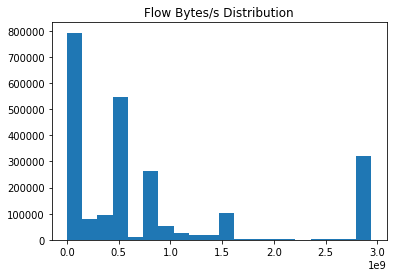

time: 568 ms


In [249]:
# 'Flow Bytes/s' distribution
plt.figure()
plt.hist(all_df['Flow Bytes/s'], bins=20)
plt.title('Flow Bytes/s Distribution')
plt.show()

In [250]:
# Which class has null values
g = all_df.groupby(' Label')
g = g.count().rsub(g.size(), axis=0)
g['Flow Bytes/s']

 Label
0       32
1        1
2        0
3        1
4    40264
5        0
Name: Flow Bytes/s, dtype: int64

time: 2.38 s


In [251]:
# This takes a bit
# Filling nans with medians of each class
all_df['Flow Bytes/s'] = all_df.groupby(" Label").transform(lambda x: x.fillna(x.median()))

time: 3min 35s


In [253]:
# Finding nans
all_df['Flow Bytes/s'].isna().sum()

0

time: 6.15 ms


### Defining variables

In [255]:
# Defining vaariables 
X = all_df.iloc[:,:-1]
y = all_df.iloc[:,-1]

time: 2.52 s


In [188]:
# This takes a bit to run
# Applying Lasso regression
lasso_all_df = Lasso()
lasso_all_df.fit(X,y)

lasso_all_df.coef_

array([-1.35800177e-05,  6.91145465e-07, -0.00000000e+00, -1.81658544e-09,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        2.79192329e-03, -0.00000000e+00,  0.00000000e+00,  2.25948944e-02,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        7.65340166e-06, -1.17549891e-07, -3.54779040e-08,  2.51586440e-07,
        9.87639062e-09, -5.45740878e-07, -9.53267909e-10,  3.30382024e-07,
        3.70462029e-08,  9.07164473e-09,  0.00000000e+00, -3.22977195e-08,
        1.65163355e-07, -1.64829966e-07,  7.31088257e-08, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.18691128e-11,  1.38661417e-09, -1.46424798e-07, -4.21676103e-06,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.79015347e-05,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

time: 3min 23s


In [189]:
# Creating dataframe for lasso coeffs
a = [X.columns, lasso_all_df.coef_]
df_lasso = pd.DataFrame(a).T

time: 93 ms


In [190]:
# Renaming columns
df_lasso = df_lasso.rename(columns={0:'variables', 1:'coeff'})

time: 10.5 ms


In [191]:
# Sorting 
df_lasso.sort_values(by='coeff', ascending=False)

,variables,coeff
11,Fwd Packet Length Std,0.0225949
55,Avg Fwd Segment Size,0.00393032
8,Fwd Packet Length Max,0.00279192
65,Subflow Fwd Bytes,0.000179728
68,Init_Win_bytes_forward,0.000146134
16,Flow Bytes/s,7.6534e-06
1,Destination Port,6.91145e-07
72,Active Mean,4.30258e-07
23,Fwd IAT Mean,3.30382e-07
19,Flow IAT Std,2.51586e-07


time: 23.8 ms


In [192]:
# Assignig zero coefficients 
zero_coeffs = df_lasso[df_lasso.coeff == 0]

# Values of zero lasso coefficients
zero_coeffs['variables'].values

array([' Protocol', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std',
       ' Fwd IAT Min', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Min Packet Length',
       ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std',
       'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count',
       ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count',
       ' CWE Flag Count', ' ECE Flag Count', ' Down/Up Ratio',
       ' Avg Bwd Segment Size', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
       ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Bwd Packets',
       ' Subflow Bwd Bytes', ' act_data_pk

time: 8.2 ms


In [256]:
# Dropping zero coefficient variables
all_df = all_df.drop(columns=[' Protocol', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std',
       ' Fwd IAT Min', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Min Packet Length',
       ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std',
       'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count',
       ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count',
       ' CWE Flag Count', ' ECE Flag Count', ' Down/Up Ratio',
       ' Avg Bwd Segment Size', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
       ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Bwd Packets',
       ' Subflow Bwd Bytes', ' act_data_pkt_fwd', ' Inbound'])

time: 529 ms


In [257]:
all_df.shape

(2386803, 40)

time: 4.35 ms


In [258]:
# Destination Port and Source Port will be dropped as they're both identifier variables 
# Including them in model would likely result in data leakage
all_df = all_df.drop(columns=[' Destination Port', ' Source Port'])

time: 481 ms


In [349]:
# Reassigning X
X = all_df.iloc[:,:-1]
y = all_df.iloc[:,-1]

time: 1.75 s


### Splitting data

In [350]:
# Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=1)

time: 3.42 s


### My first DT - unbalanced data

In [351]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

time: 2.14 ms


In [352]:
# This takes long
# GridSearch for decision tree classifier 
params = {'max_depth':[5,10,15,20]}

grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5)

grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.99
Best parameters:  {'max_depth': 15}
Best estimator:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
time: 6min 3s


In [353]:
my_DT = DecisionTreeClassifier(max_depth=15)
my_DT.fit(X_train,y_train)
print(f'Score on train: {my_DT.score(X_train, y_train)}')
print(f'Score on test: {my_DT.score(X_test, y_test)}')

Score on train: 0.9936840186818976
Score on test: 0.9930241473434152
time: 27.3 s


In [354]:
# Creating a dataframe for gini feature importance 
feat_imp=[X.columns, my_DT.feature_importances_]
df_feat_imp =pd.DataFrame(feat_imp).T
df_feat_imp = df_feat_imp.rename(columns= {0:'Variables', 1:'Gini_Importance'})

time: 28.3 ms


In [355]:
df_feat_imp.sort_values(by='Gini_Importance', ascending=False).head(10)

,Variables,Gini_Importance
1,Fwd Packet Length Max,0.322797
22,Average Packet Size,0.265005
23,Avg Fwd Segment Size,0.254379
3,Flow Bytes/s,0.143218
26,Init_Win_bytes_forward,0.00757908
25,Subflow Fwd Bytes,0.00300818
28,min_seg_size_forward,0.00130968
21,Packet Length Variance,0.000976774
17,Fwd Header Length,0.000565324
24,Fwd Header Length.1,0.000458267


time: 10.6 ms


In [356]:
from sklearn.metrics import confusion_matrix
# Defining y predict

y_pred = my_DT.predict(X_test)
from sklearn.metrics import confusion_matrix

# Confusion mastrix
confusion_matrix(y_test, y_pred)

array([[  1572,      1,      2,      0,      0,      0],
       [     2,  35326,    218,    155,      0,    479],
       [     0,     22,  87145,      3,      1,     26],
       [     4,   1754,      4, 161903,      0,     66],
       [     0,      5,      0,      2,  63282,      3],
       [     0,    552,     18,     11,      2, 124803]])

time: 445 ms


In [361]:
# Creating a df of confusion matrix
con_mat = confusion_matrix(y_test, y_pred) 
df_conmat = pd.DataFrame(con_mat, columns=['Predictec Class 0', 'Predicted Class 1','Predicted Class 2','Predicted Class 3','Predicted Class 4','Predicted Class 5'] )
df_conmat = df_conmat.rename('True {}'.format)
df_conmat.style.background_gradient(cmap='GnBu')

,Predictec Class 0,Predicted Class 1,Predicted Class 2,Predicted Class 3,Predicted Class 4,Predicted Class 5
True 0,1572,1,2,0,0,0
True 1,2,35326,218,155,0,479
True 2,0,22,87145,3,1,26
True 3,4,1754,4,161903,0,66
True 4,0,5,0,2,63282,3
True 5,0,552,18,11,2,124803


time: 368 ms


In [358]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1575
           1       0.94      0.98      0.96     36180
           2       1.00      1.00      1.00     87197
           3       1.00      0.99      0.99    163731
           4       1.00      1.00      1.00     63292
           5       1.00      1.00      1.00    125386

    accuracy                           0.99    477361
   macro avg       0.99      0.99      0.99    477361
weighted avg       0.99      0.99      0.99    477361

time: 555 ms


### My second DT - Resampled balanced train data

In [363]:
# Undersampling for more managable data
from imblearn.under_sampling import RandomUnderSampler
print('Original dataset shape %s' % Counter(y_train))
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({3: 654925, 5: 501543, 2: 348789, 4: 253166, 1: 144720, 0: 6299})
Resampled dataset shape Counter({0: 6299, 1: 6299, 2: 6299, 3: 6299, 4: 6299, 5: 6299})
time: 1.95 s


In [364]:
# GridSearch for second decision tree classifier 
params = {'max_depth':[5,10,15,20]}

grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5)

grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.99
Best parameters:  {'max_depth': 10}
Best estimator:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
time: 2.8 s


In [365]:
my_DT2 = DecisionTreeClassifier(max_depth=10)
my_DT2.fit(X_train,y_train)
print(f'Score on train: {my_DT2.score(X_train, y_train)}')
print(f'Score on test: {my_DT2.score(X_test, y_test)}')

Score on train: 0.9944171032439012
Score on test: 0.9891612427491981
time: 456 ms


In [366]:
# New feature importance dataframe
feat_imp = [X.columns, my_DT2.feature_importances_]
df_feat_imp = pd.DataFrame(feat_imp).T
df_feat_imp = df_feat_imp.rename(columns= {0:'Variables', 1:'Gini_Importance'})
df_feat_imp.sort_values(by='Gini_Importance', ascending=False).head()

,Variables,Gini_Importance
23,Avg Fwd Segment Size,0.394213
3,Flow Bytes/s,0.202639
22,Average Packet Size,0.192328
4,Flow Packets/s,0.110732
26,Init_Win_bytes_forward,0.0570107


time: 20.9 ms


In [367]:
# Defining y predict
y_pred = my_DT2.predict(X_test)
from sklearn.metrics import confusion_matrix

# Confusion mastrix
confusion_matrix(y_test, y_pred)

array([[  1574,      0,      0,      0,      1,      0],
       [     3,  35848,    206,     52,      0,     71],
       [    14,    183,  86974,      6,      2,     18],
       [    38,   2072,     12, 161602,      1,      6],
       [    53,      6,      2,      0,  63229,      2],
       [    94,   2164,     58,     14,     96, 122960]])

time: 455 ms


In [372]:
# Creating a df of confusion matrix
con_mat = confusion_matrix(y_test, y_pred) 
df_conmat = pd.DataFrame(con_mat, columns=['Predictec Class 0', 'Predicted Class 1','Predicted Class 2','Predicted Class 3','Predicted Class 4','Predicted Class 5'] )
df_conmat = df_conmat.rename('True {}'.format)
df_conmat.style.background_gradient(cmap='PuBuGn')

,Predictec Class 0,Predicted Class 1,Predicted Class 2,Predicted Class 3,Predicted Class 4,Predicted Class 5
True 0,1574,0,0,0,1,0
True 1,3,35848,206,52,0,71
True 2,14,183,86974,6,2,18
True 3,38,2072,12,161602,1,6
True 4,53,6,2,0,63229,2
True 5,94,2164,58,14,96,122960


time: 331 ms


In [373]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1575
           1       0.89      0.99      0.94     36180
           2       1.00      1.00      1.00     87197
           3       1.00      0.99      0.99    163731
           4       1.00      1.00      1.00     63292
           5       1.00      0.98      0.99    125386

    accuracy                           0.99    477361
   macro avg       0.96      0.99      0.98    477361
weighted avg       0.99      0.99      0.99    477361

time: 585 ms


In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(my_DT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### My 1st logistic regression on resampled balanced data

In [ ]:
# Searching optimal hyperparameters
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
            ,'penalty': ['l1','l2']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_res, y_res)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

### Converting multiclass to binary

In [284]:
pd.set_option('display.min_rows', None)

time: 5.04 ms


In [288]:
# Converting multiclass to binary
bin_df = all_df.replace({' Label': {1:'1', 2:'1', 3:'1', 4:'1', 5:'1', 0:'0'}})

time: 2.28 s


In [289]:
# Converting to type int
bin_df[' Label'].astype(int)
pd.set_option('display.min_rows', None)

time: 280 ms


In [293]:
# Variable assignment
X = bin_df.iloc[:,:-1]
y = bin_df.iloc[:,-1]

time: 1.59 s


In [294]:
# Variable splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=1)

time: 3.33 s


In [295]:
# Undersampling again
print('Original dataset shape %s' % Counter(y_train))
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({'1': 1903143, '0': 6299})
Resampled dataset shape Counter({'0': 6299, '1': 6299})
time: 5.13 s


In [296]:
# GridSearch for second decision tree classifier 
params = {'max_depth':[5,10,15,20]}

grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5)

grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 1.00
Best parameters:  {'max_depth': 20}
Best estimator:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
time: 1.35 s


In [303]:
my_DT3 = DecisionTreeClassifier(max_depth=20)
my_DT3.fit(X_train,y_train)
print(f'Score on train: {my_DT3.score(X_train, y_train)}')
print(f'Score on test: {my_DT3.score(X_test, y_test)}')

Score on train: 1.0
Score on test: 0.9986236831245117
time: 1.07 s


In [307]:
# New feature importance dataframe
feat_imp = [X.columns, my_DT3.feature_importances_]
df_feat_imp = pd.DataFrame(feat_imp).T
df_feat_imp = df_feat_imp.rename(columns= {0:'Variables', 1:'Gini_Importance'})
df_feat_imp.sort_values(by='Gini_Importance', ascending=False).head()

,Variables,Gini_Importance
23,Avg Fwd Segment Size,0.700124
26,Init_Win_bytes_forward,0.138885
4,Flow Packets/s,0.0979884
21,Packet Length Variance,0.0443354
3,Flow Bytes/s,0.0103915


time: 12.2 ms


In [308]:
# Defining y predict
y_pred = my_DT3.predict(X_test)
from sklearn.metrics import confusion_matrix

# Confusion mastrix
confusion_matrix(y_test, y_pred)

array([[  1575,      0],
       [   657, 475129]])

time: 1.87 s


In [309]:
# Creating a df of confusion matrix
con_mat = confusion_matrix(y_test, y_pred) 
df_conmat = pd.DataFrame(con_mat, columns=['Predictec Class 0', 'Predicted Class 1'] )
df_conmat = df_conmat.rename('True {}'.format)
df_conmat.style.background_gradient(cmap='PRGn')

,Predictec Class 0,Predicted Class 1
True 0,1575,0
True 1,657,475129


time: 1.71 s


In [310]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1575
           1       1.00      1.00      1.00    475786

    accuracy                           1.00    477361
   macro avg       0.85      1.00      0.91    477361
weighted avg       1.00      1.00      1.00    477361

time: 14.1 s


In [313]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

time: 3.35 ms


In [323]:
# XG Boost Classifier
XGB_model = XGBClassifier()

XGB_model.fit(X_train, y_train)

print(f"XG Boost test score: {XGB_model.score(X_test, y_test)}")

XG Boost test score: 0.9995077100978086
time: 4.03 s


In [324]:
# Y predict of XGB
y_predXGB = XGB_model.predict(X_test)
print(f"XG Boost Classification Report: \n {(classification_report(y_test, y_predXGB))}")


XG Boost Classification Report: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      1575
           1       1.00      1.00      1.00    475786

    accuracy                           1.00    477361
   macro avg       0.94      1.00      0.97    477361
weighted avg       1.00      1.00      1.00    477361

time: 15.5 s


In [321]:
# Creating a df of confusion matrix
con_mat = confusion_matrix(y_test, y_predXGB) 
df_conmat = pd.DataFrame(con_mat, columns=['Predictec Class 0', 'Predicted Class 1'] )
df_conmat = df_conmat.rename('True {}'.format)
df_conmat.style.background_gradient(cmap='PRGn')

,Predictec Class 0,Predicted Class 1
True 0,1574,1
True 1,234,475552


time: 1.74 s


In [331]:
my_DT4 = DecisionTreeClassifier(max_depth=5)
my_DT4.fit(X_train,y_train)
print(f'Score on train: {my_DT4.score(X_train, y_train)}')
print(f'Score on test: {my_DT4.score(X_test, y_test)}')

Score on train: 0.9986505794570567
Score on test: 0.9965686346391934
time: 1.11 s


In [332]:
# Defining y predict
y_pred4 = my_DT4.predict(X_test)
from sklearn.metrics import confusion_matrix

# Confusion mastrix
confusion_matrix(y_test, y_pred4)

array([[  1575,      0],
       [  1638, 474148]])

time: 2 s


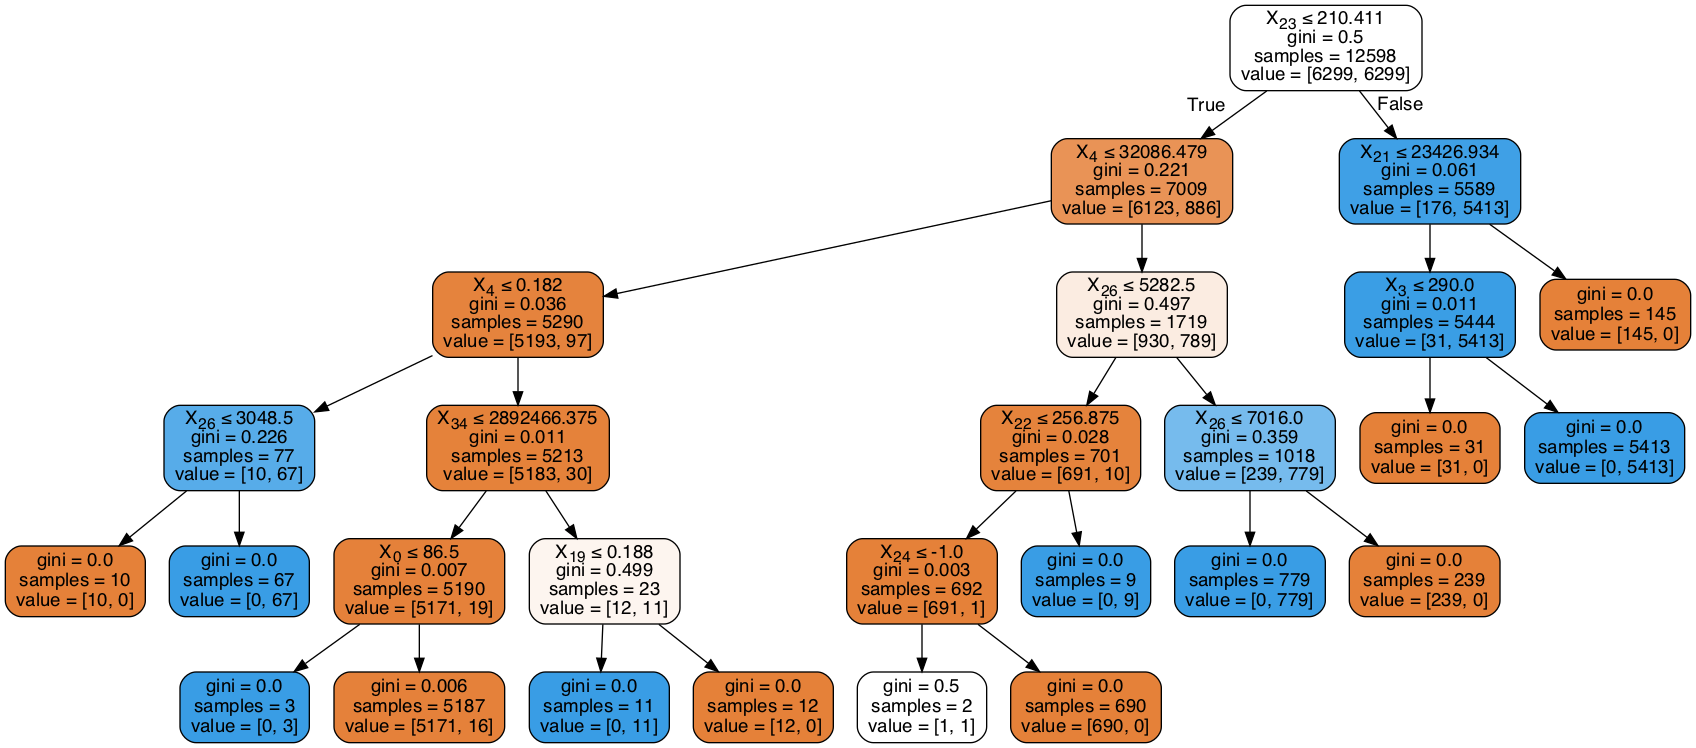

time: 893 ms


In [333]:
dot_data = StringIO()

export_graphviz(my_DT4, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
# Pickling model for reuse
import joblib
joblib.dump(my_DT2, 'my_dt2.pkl')
my_dt2_reloaded = joblib.load('my_dt2.pkl')